In [34]:
import notebook_setup

import jax.numpy as jnp
import pandas as pd

import src.utils.pandas_utils as pdu
from src.utils.misc import generate_interval_requirements

from src.generators.shift_requirements import (
    ShiftRequirementsGenerator,
    SRGeneratorParams,
    StochasticRoundingParams,
    GradientDescentParams,
)

from src.entities.data_classes import Shift
from src.entities.shifts import RequirementShift

#### **Defining Shift Blueprints**

- **Shift list**: In order to initialize a the ShiftRequirements class we must provide a list of Shift Blueprints. They must have different names.

- **Custom coverage**: Advanced feature. Allows editing how much coverage each shift provides to the total coverage.

In [38]:
# Defining a series of shift blueprints, in this example all shifts starting an ODD hours
# and that with a duration 9 INTERVALS

db_shifts = [
    Shift(id=f"S{start}", skill="basic", start_time=start, duration=9)
    for start in jnp.arange(0, 24, 2)
]


shifts = [
    RequirementShift(
        shift,
        daily_intervals=24,  # dividing start times in intervals of 24 hours
        coverage=jnp.ones(9) * 0.95,  # Shifts provide 95% of coverage instead of 100%
    )
    for shift in db_shifts
]

shifts[0].lower_bounds = [1, 1, 1, 1, 1, 0, 0]
shifts[3].lower_bounds = [1, 0]

#### **Generating Shift Requirements**

- **Initialize ShiftRequirementsGenerator**: Create an instance of the class <code>ShiftRequirementsGenerator</code>.

- **Adjust Params**: We can change some og the algorythm parameters by loading a valid Params class instance using the <code>set_params</code> method.

- **Generate**: Running the <code>generate</code> method returns the an instance of <code>ShiftRequirementsghts</code>, that contains the final weights, the run parameters and the evolution of weights throughout the sub-processes.

In [79]:
# Initialize Shift Requirements
num_weeks = 5

sr_gen = ShiftRequirementsGenerator(shifts=shifts, days=num_weeks * 7)

# Custom Parameters
sr_gen.set_params(
    SRGeneratorParams(
        daily_intervals=24,
        asymetric_weight=0.8,
        gradient_descent=GradientDescentParams(
            learning_rate=1, num_iterations=10000, snapshot_length=50
        ),
        stochastic_rounding=StochasticRoundingParams(section_size=24, passes=25),
    )
)

#
int_reqs = generate_interval_requirements(
    weeks=num_weeks, base_demand=25, cycle_amplitude=20
)

# Generate Requirements
shift_reqs = sr_gen.generate(interval_reqs=int_reqs)

--- GRADIENT DESCENT ---
Iteration 0: Error = 620.22119140625
Iteration 50: Error = 6.448765277862549
Iteration 100: Error = 3.6899633407592773
Iteration 150: Error = 3.415968894958496
Iteration 200: Error = 3.327176809310913
Iteration 250: Error = 3.278402328491211
Iteration 300: Error = 3.2468113899230957
Iteration 350: Error = 3.223475694656372
Iteration 400: Error = 3.20503568649292
Iteration 450: Error = 3.190173864364624
Iteration 500: Error = 3.1780686378479004
Iteration 550: Error = 3.1684157848358154
Iteration 600: Error = 3.1606667041778564
Iteration 650: Error = 3.1541876792907715
Iteration 700: Error = 3.1486964225769043
Iteration 750: Error = 3.1440231800079346
Iteration 800: Error = 3.1400153636932373
Iteration 850: Error = 3.136549472808838
Iteration 900: Error = 3.1335220336914062
Iteration 950: Error = 3.1308650970458984
Iteration 1000: Error = 3.128525972366333
Iteration 1050: Error = 3.126465320587158
Iteration 1100: Error = 3.124659538269043
Iteration 1150: Error = 

#### Exploring Results:

Diff between GD and SR final result:
 mean -> 0.01 | sum -> 6.28


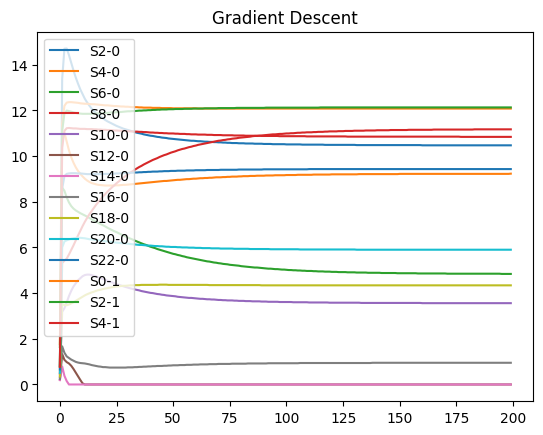

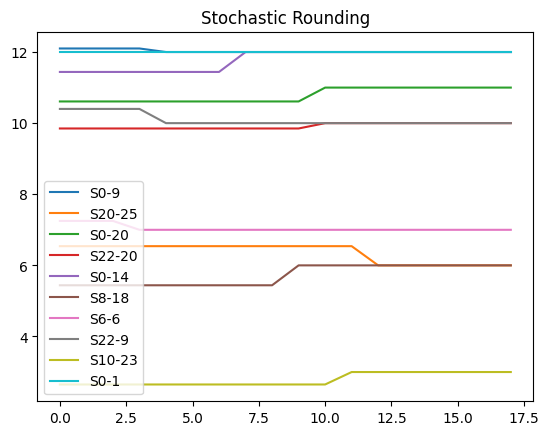

In [80]:
# Evolution DataFrames
gradient_evol_df = pdu.evolution_df("gd_evolution", shift_reqs)

stoch_round_evol_df = pdu.evolution_df("sr_evolution", shift_reqs)

# Visualize Gradient Evolution
gradient_evol_df.iloc[:, 1:15].plot(title="Gradient Descent")

# Visualize Gradient Evolution
stoch_round_evol_df.transpose().sample(10).transpose().plot(title="Stochastic Rounding")

# Last Step Comparison
last_steps_diff = stoch_round_evol_df.iloc[-1].values - gradient_evol_df.iloc[-1].values

print(
    f"Diff between GD and SR final result:\n mean -> {last_steps_diff.mean().round(2)} | sum -> {last_steps_diff.sum().round(2)}"
)

<Axes: >

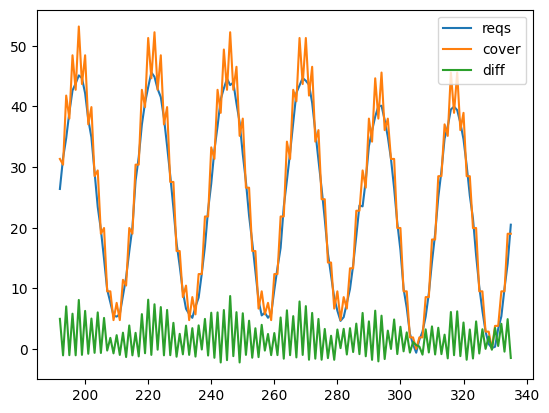

In [81]:
pdu.shift_reqs_coverage_df(shift_reqs)[24 * 8 : 24 * 14].plot()

In [82]:
pdu.shift_reqs_results_df(shift_reqs).pivot(
    columns="shift_name", index="day_index", values="req"
)

shift_name,S0,S10,S12,S14,S16,S18,S2,S20,S22,S4,S6,S8
day_index,,,,,,,,,,,,
0,28.0,3.0,0.0,0.0,1.0,4.0,10.0,6.0,9.0,10.0,5.0,11.0
1,12.0,3.0,1.0,0.0,1.0,3.0,12.0,7.0,10.0,11.0,10.0,5.0
2,12.0,3.0,0.0,0.0,2.0,4.0,12.0,7.0,10.0,12.0,8.0,6.0
3,12.0,3.0,0.0,0.0,3.0,2.0,12.0,8.0,10.0,11.0,9.0,5.0
4,13.0,2.0,0.0,0.0,3.0,4.0,12.0,6.0,10.0,11.0,8.0,5.0
5,8.0,0.0,0.0,0.0,0.0,2.0,12.0,7.0,10.0,11.0,8.0,2.0
6,11.0,0.0,0.0,0.0,0.0,3.0,10.0,7.0,10.0,10.0,7.0,3.0
7,11.0,4.0,0.0,0.0,1.0,4.0,12.0,6.0,10.0,12.0,9.0,6.0
8,12.0,3.0,1.0,1.0,0.0,3.0,12.0,7.0,10.0,11.0,11.0,5.0
